#### This notebook takes the raw data from the API and processes it to the modeling data.

#### 2) Moving averages, percent changes, and z-scores are calcuated for the 21 ticker symbols. These are written to interim data as "processed" individual csv files.

#### 3) Histograms were generated for means of z-scores. Four of the original 25 tickers were removed based on unusual z-scores or volume data issues. JNK was removed due to weirdly high open z-score mean, HYG was removed due to weirdly low low z-score mean, and EWZ/IEF had volume data isses (infinite end values). These values can be seen in a table <a href='https://docs.google.com/spreadsheets/d/1ekkdNC7Cg0UogQIs47jpgDZtKHj7IqdhR1BB1X-emIc/edit?usp=sharing'>here</a> and in a histogram <a href='https://github.com/trentleslie/springboard_final_capstone/blob/main/docs/all_low_z_means.png'>here</a>.

#### 4) Rolling window processing is then conductecd on the individual processed csv files. For each rolling window size, the window is flattened to one row, added to a ticker dataframe, and written to its an individual csv file for each ticker's flattened data.
#### 5) The flattened data sets for each ticker are then concatentated and written to a csv file for each window size in the final processed data folder.

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join

In [2]:
window_sizes = [5, 10, 20]

def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

5 z-score mean histograms
5 z-score std histograms
10 z-score mean histograms
10 z-score std histograms
20 z-score mean histograms
20 z-score std histograms


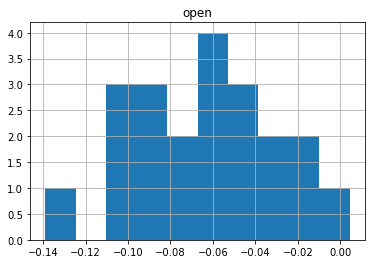

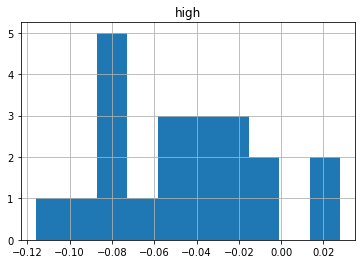

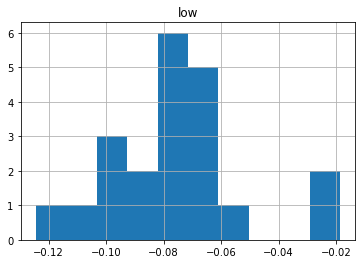

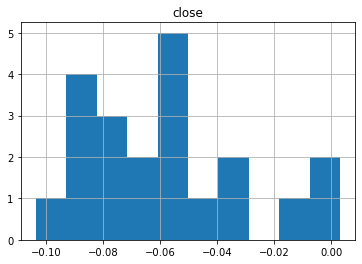

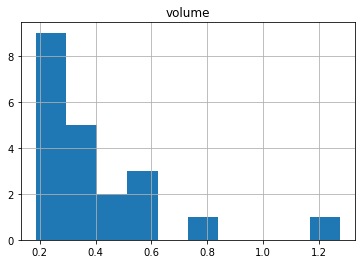

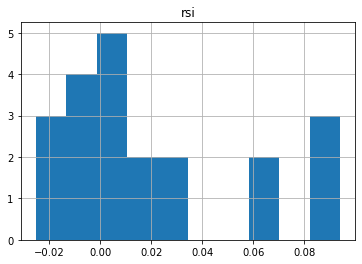

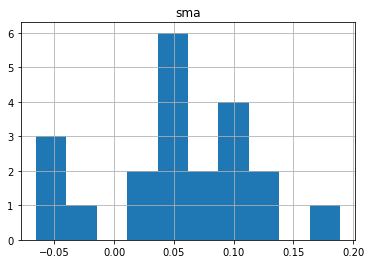

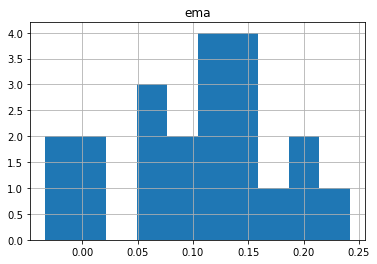

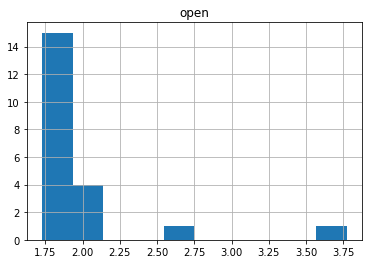

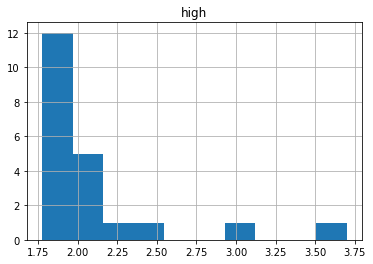

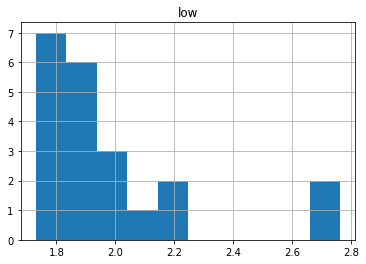

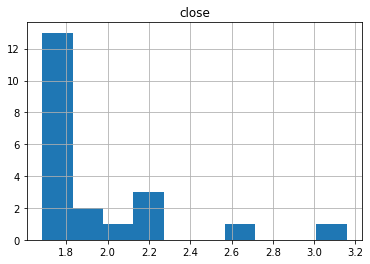

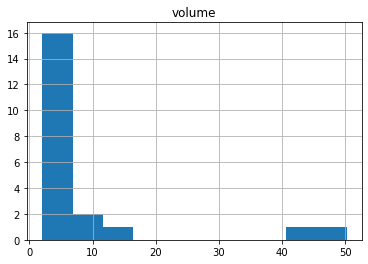

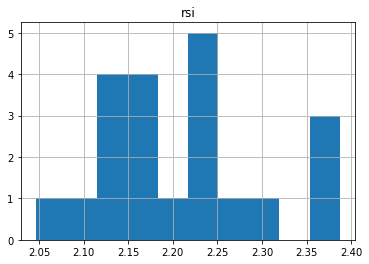

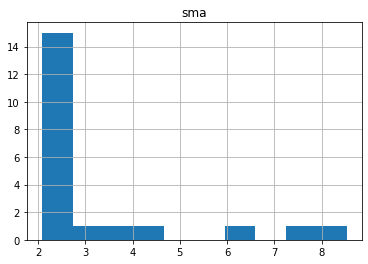

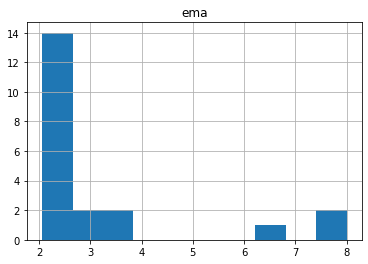

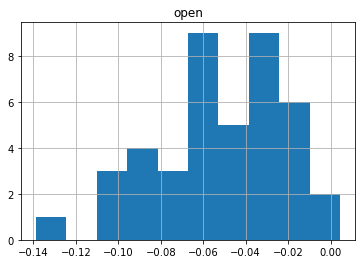

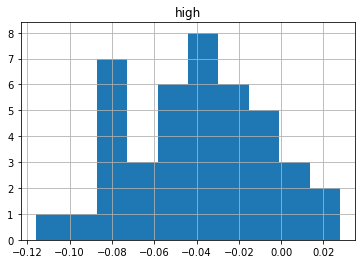

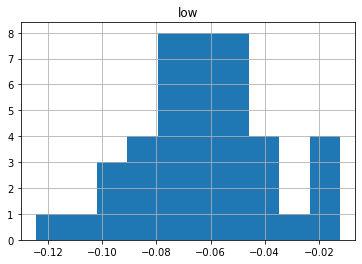

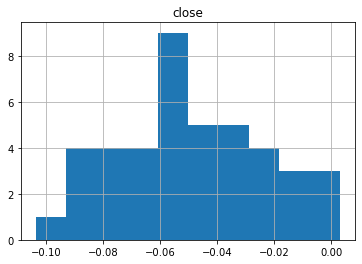

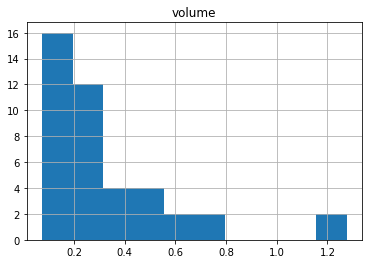

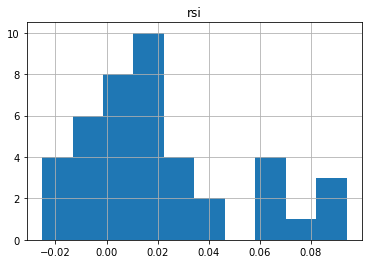

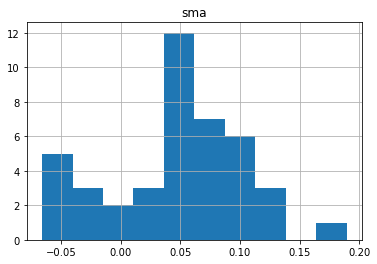

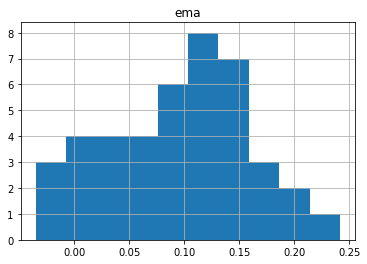

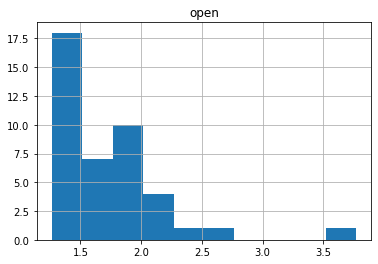

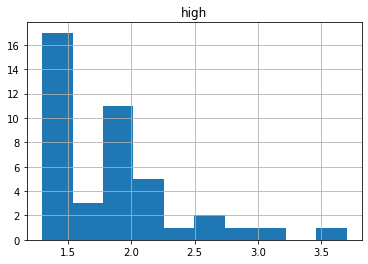

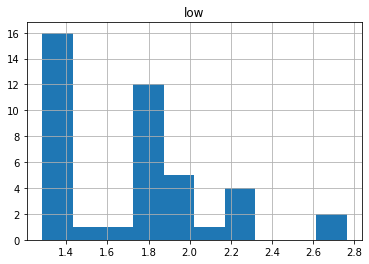

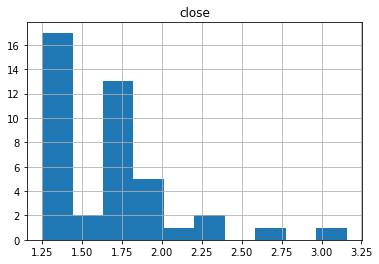

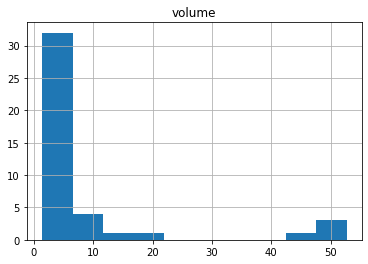

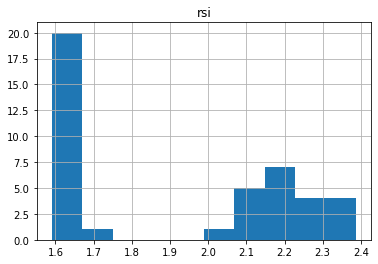

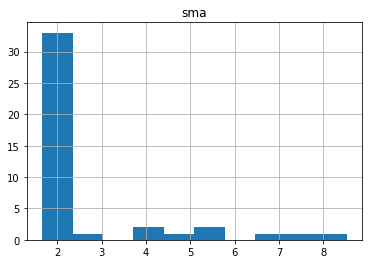

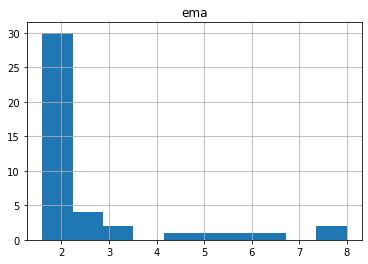

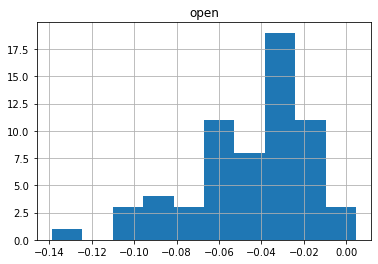

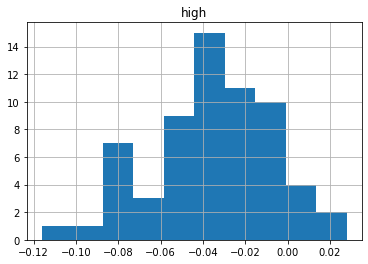

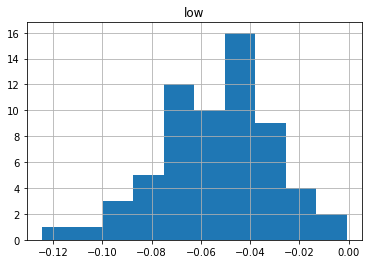

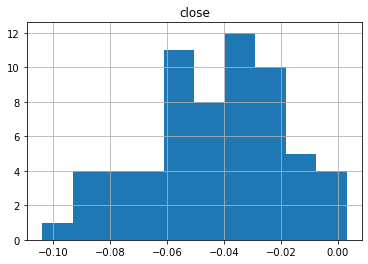

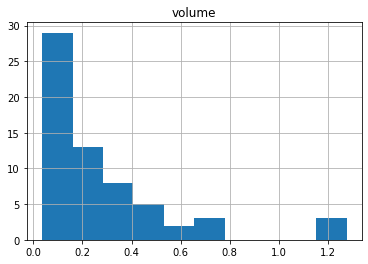

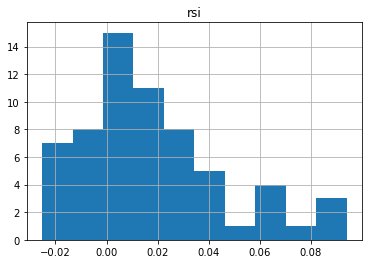

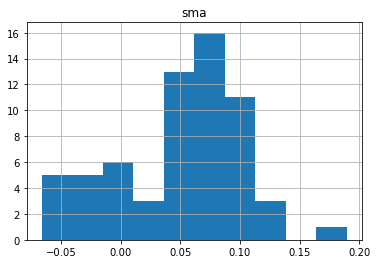

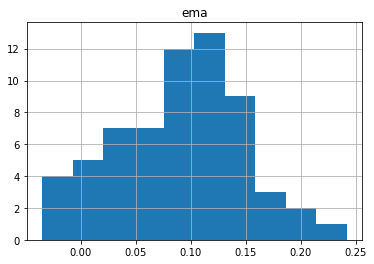

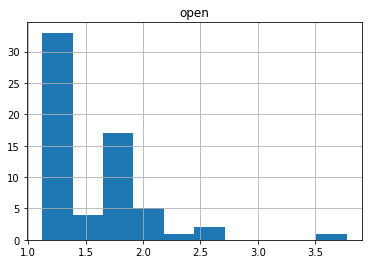

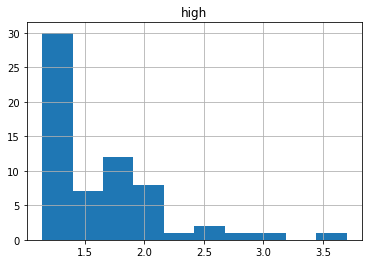

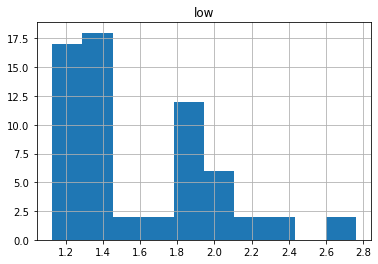

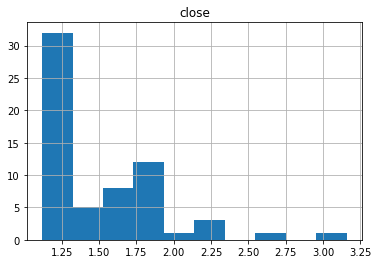

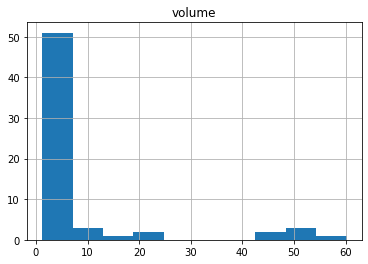

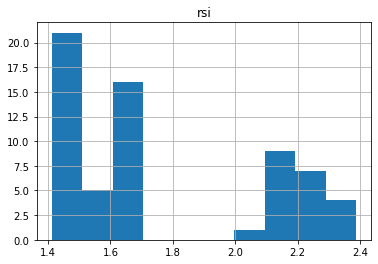

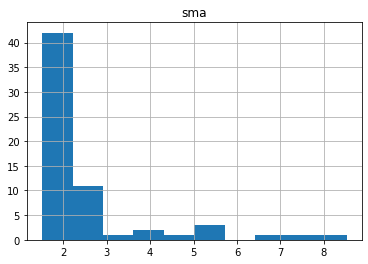

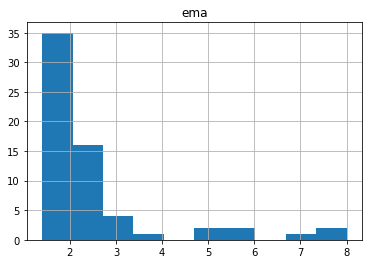

In [4]:
onlyfiles = [f for f in listdir('../data/raw/') if isfile(join('../data/raw/', f))]
onlyfiles = list(filter(lambda thisfilename: '_daily.csv' in thisfilename, onlyfiles))

ticker_list = []
ticker_stats_mean = pd.DataFrame()
ticker_stats_std = pd.DataFrame()

for window_size in window_sizes:
    for filename in onlyfiles:
        ticker = filename.split('_')[0]
        ticker_list.append(ticker)
        
        # import csv, sort by date so percent change works, drop unneeded columns,
        # rename columns, calculate moving averages, calulate percent changes, drop na's
        df = pd.read_csv(f"../data/raw/{ticker}_daily.csv")
        df.sort_index(inplace=True, ascending=False)
        df = df.drop(['Unnamed: 0','5. adjusted close', '7. dividend amount', '8. split coefficient','SMA','EMA'], axis=1)
        df.columns = ['open','high','low','close','volume','rsi']

        # moving averages, convert to percentage of close
        df['sma'] = df.iloc[:,3].rolling(window=50).mean()/df.iloc[:,3]
        df['ema'] = df.iloc[:,3].ewm(span=21).mean()/df.iloc[:,3]

        # percent change
        df['open'] = df['open'].pct_change()
        df['high'] = df['high'].pct_change()
        df['low'] = df['low'].pct_change()
        df['close'] = df['close'].pct_change()
        df['volume'] = df['volume'].pct_change()
        df = df.dropna()

        # zscore
        df['open'] =zscore(df['open'], window=window_size)
        df['high'] = zscore(df['high'], window=window_size)
        df['low'] = zscore(df['low'], window=window_size)
        df['close'] = zscore(df['close'], window=window_size)
        df['volume'] = zscore(df['volume'], window=window_size)
        df['rsi'] = zscore(df['rsi'], window=window_size)
        df['sma'] = zscore(df['sma'], window=window_size)
        df['ema'] = zscore(df['ema'], window=window_size)
        df = df.dropna()

        # ticker mean stats
        temp = pd.DataFrame(df.describe()).iloc[1:2,]
        temp['ticker'] = ticker
        ticker_stats_mean = pd.concat([ticker_stats_mean, temp])
        ticker_stats_mean.to_csv(f"../data/interim/ticker_stats_mean_{window_size}.csv")
        
        # ticker std stats
        temp = pd.DataFrame(df.describe()).iloc[2:3,]
        temp['ticker'] = ticker
        ticker_stats_std = pd.concat([ticker_stats_std, temp])
        ticker_stats_std.to_csv(f"../data/interim/ticker_stats_std_{window_size}.csv")

        # write data and describe to csv
        df.to_csv(f"../data/interim/{ticker}_{window_size}_processed.csv")
        df.describe().to_csv(f"../data/interim/{ticker}_{window_size}_describe.csv")
    
    print(f"{window_size} z-score mean histograms")
    ticker_stats_mean.hist(column='open', bins=10)
    ticker_stats_mean.hist(column='high', bins=10)
    ticker_stats_mean.hist(column='low', bins=10)
    ticker_stats_mean.hist(column='close', bins=10)
    ticker_stats_mean.hist(column='volume', bins=10)
    ticker_stats_mean.hist(column='rsi', bins=10)
    ticker_stats_mean.hist(column='sma', bins=10)
    ticker_stats_mean.hist(column='ema', bins=10)

    print(f"{window_size} z-score std histograms")
    ticker_stats_std.hist(column='open', bins=10)
    ticker_stats_std.hist(column='high', bins=10)
    ticker_stats_std.hist(column='low', bins=10)
    ticker_stats_std.hist(column='close', bins=10)
    ticker_stats_std.hist(column='volume', bins=10)
    ticker_stats_std.hist(column='rsi', bins=10)
    ticker_stats_std.hist(column='sma', bins=10)
    ticker_stats_std.hist(column='ema', bins=10)
ticker_list = set(ticker_list)

In [22]:
# iterating through the window sizes provided in the list above
for window_size in window_sizes:
    print(f"starting window size: {window_size}")
    
    # iterating through the list of processed files
    for ticker in ticker_list:
        # empty dataframe for this ticker's flattened data
        flattened_df = pd.DataFrame()
        df = pd.read_csv(f"../data/interim/{ticker}_{window_size}_processed.csv").drop(['Unnamed: 0'], axis=1)
        
        # iterating through grouped rows (window size)
        for i in range(df.shape[0]-window_size+1):
            # resetting the index each time so column names align
            df_window = df.iloc[i:i+window_size,].reset_index(drop=True)
            # mapping the index as a string so it can be concatenated
            df_window.index = df_window.index.map(str)
            # unstacking the window to one row
            df_window = df_window.unstack().to_frame().sort_index(level=1).T
            # renaming the columns
            df_window.columns = df_window.columns.map('_'.join)
            # concatenating the flattened row to the dataframe
            flattened_df = pd.concat([flattened_df, df_window], axis=0)
        
        # writing the flattened dataframe for this ticker and window size to csv
        flattened_df.to_csv(f"../data/interim/{ticker}_{window_size}_flattened.csv")
        print(f"{ticker} {window_size} flattened")
    
    # getting list of flattened ticker files generated above for this window size
    onlyfiles_flattened = [f for f in listdir('../data/interim/') if isfile(join('../data/interim/', f))]
    onlyfiles_flattened = list(filter(lambda thisfilename: f"{window_size}_flattened.csv" in thisfilename, onlyfiles_flattened))
    
    # creating an empty dataframe for the combined flattened data
    all_data_combined = pd.DataFrame()

    # iterating through the list of flattened files for this window size and concatenating them to the dataframe
    for filename in onlyfiles_flattened:
        ticker = filename.split('_')[0]
        all_data_combined = pd.concat([all_data_combined, pd.read_csv(f"../data/interim/{ticker}_{window_size}_flattened.csv").drop(['Unnamed: 0'], axis=1)])
    
    all_data_combined = all_data_combined.drop([f"volume_{window_size-1}", f"rsi_{window_size-1}", f"sma_{window_size-1}", f"ema_{window_size-1}"], axis=1)
    
    # writing the combined flattened dataframe for this window size to csv in the processed folder    
    all_data_combined.to_csv(f"../data/processed/all_processed_{window_size}.csv")
    print(f"window {window_size} data combined")
    print(all_data_combined.shape)


starting window size: 5
SPY 5 flattened
XLF 5 flattened
VWO 5 flattened
IEMG 5 flattened
BND 5 flattened
XLK 5 flattened
QQQ 5 flattened
EEM 5 flattened
GDX 5 flattened
FXI 5 flattened
LQD 5 flattened
SLV 5 flattened
JETS 5 flattened
TLT 5 flattened
XLE 5 flattened
XLV 5 flattened
IWM 5 flattened
EFA 5 flattened
XLB 5 flattened
XLI 5 flattened
XLU 5 flattened
window 5 data combined
(96618, 36)
starting window size: 10
SPY 10 flattened
XLF 10 flattened
VWO 10 flattened
IEMG 10 flattened
BND 10 flattened
XLK 10 flattened
QQQ 10 flattened
EEM 10 flattened
GDX 10 flattened
FXI 10 flattened
LQD 10 flattened
SLV 10 flattened
JETS 10 flattened
TLT 10 flattened
XLE 10 flattened
XLV 10 flattened
IWM 10 flattened
EFA 10 flattened
XLB 10 flattened
XLI 10 flattened
XLU 10 flattened
window 10 data combined
(96408, 76)
starting window size: 20
SPY 20 flattened
XLF 20 flattened
VWO 20 flattened
IEMG 20 flattened
BND 20 flattened
XLK 20 flattened
QQQ 20 flattened
EEM 20 flattened
GDX 20 flattened
FXI 

In [ ]:
#window 5: 96618 rows, 36 columns (32 features, 4 targets)
#window 10: 96408 rows, 76 columns (72 features, 4 targets)
#window 20: 95988 rows, 156 columns (152 features, 4 targets)

# from 5 to 10, losing 10 rows per ticker, so with 21 tickers, 21 * 10 = 210 rows lost
# from 10 to 20, losing an additional 20 rows per ticker, so 21 * 20 = 420 rows lost (630 total)